In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from shapely import wkt
import contextily as ctx

In [2]:
#Read the datasets using pandas read_csv function
cri_data = pd.read_csv('/Users/zamiulalam/Documents/Data_Science/datasets/Chicago_Crimes/Crimes_-_2001_to_Present_20250301.csv')
com_data = pd.read_csv('/Users/zamiulalam/Documents/Data_Science/datasets/Chicago_Crimes/CommAreas_20250315.csv')
pop_data = pd.read_csv('/Users/zamiulalam/Documents/Data Science/datasets/ACS_5_Year_Data_by_Community_Area_20250302.csv')

In [3]:
cri_data.head()

ID Case Number                    Date                    Block  \
0  13311263    JG503434  07/29/2022 03:39:00 AM          023XX S TROY ST   
1  13053066    JG103252  01/03/2023 04:44:00 PM  039XX W WASHINGTON BLVD   
2  11227634    JB147599  08/26/2017 10:00:00 AM      001XX W RANDOLPH ST   
3  13203321    JG415333  09/06/2023 05:00:00 PM         002XX N Wells st   
4  13204489    JG416325  09/06/2023 11:00:00 AM           0000X E 8TH ST   

   IUCR                Primary Type                    Description  \
0  1582  OFFENSE INVOLVING CHILDREN              CHILD PORNOGRAPHY   
1  2017                   NARCOTICS  MANUFACTURE / DELIVER - CRACK   
2  0281         CRIM SEXUAL ASSAULT                 NON-AGGRAVATED   
3  1320             CRIMINAL DAMAGE                     TO VEHICLE   
4  0810                       THEFT                      OVER $500   

                     Location Description  Arrest  Domestic  ...  Ward  \
0                               RESIDENCE    True     False  ...  25.0   
1                                SIDEWALK    True     False  ...  28.0   
2                             HOTEL/MOTEL   False     False  ...  42.0   
3  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ...  42.0   
4  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False  ...   4.0   

   Community Area  FBI Code  X Coordinate Y Coordinate  Year  \
0            30.0        17           NaN          NaN  2022   
1            26.0        18           NaN          NaN  2023   
2            32.0        02           NaN          NaN  2017   
3            32.0        14     1174694.0    1901831.0  2023   
4            32.0        06     1176857.0    1896680.0  2023   

               Updated On   Latitude  Longitude                       Location  
0  04/18/2024 03:40:59 PM        NaN        NaN                            NaN  
1  01/20/2024 03:41:12 PM        NaN        NaN                            NaN  
2  02/11/2018 03:57:41 PM        NaN        NaN                            NaN  
3  11/04/2023 03:40:18 PM  41.886018 -87.633938  (41.886018055, -87.633937881)  
4  11/04/2023 03:40:18 PM  41.871835 -87.626151   (41.871834768, -87.62615082)  

[5 rows x 22 columns]

In [4]:
com_data.head()

the_geom  PERIMETER  AREA  \
0  MULTIPOLYGON (((-87.60914087617894 41.84469250...          0     0   
1  MULTIPOLYGON (((-87.59215283879394 41.81692934...          0     0   
2  MULTIPOLYGON (((-87.62879823733725 41.80189303...          0     0   
3  MULTIPOLYGON (((-87.6067081256125 41.816813770...          0     0   
4  MULTIPOLYGON (((-87.59215283879394 41.81692934...          0     0   

   COMAREA_  COMAREA_ID  AREA_NUMBE        COMMUNITY  AREA_NUM_1  \
0         0           0          35          DOUGLAS          35   
1         0           0          36          OAKLAND          36   
2         0           0          37      FULLER PARK          37   
3         0           0          38  GRAND BOULEVARD          38   
4         0           0          39          KENWOOD          39   

     SHAPE_AREA     SHAPE_LEN  
0  4.600462e+07  31027.054510  
1  1.691396e+07  19565.506153  
2  1.991670e+07  25339.089750  
3  4.849250e+07  28196.837157  
4  2.907174e+07  23325.167906

In [5]:
pop_data.head()

ACS Year  Community Area  Under $25,000  $25,000 to $49,999  \
0      2023     ALBANY PARK           1269                1916   
1      2023  ARCHER HEIGHTS            223                 752   
2      2023   ARMOUR SQUARE            701                 798   
3      2023         ASHBURN            797                1351   
4      2023  AUBURN GRESHAM           2541                2451   

   $50,000 to $74,999  $75,000 to $125,000  $125,000 +  Male 0 to 17  \
0                1801                 2306        3379          4799   
1                 441                  795         739          1927   
2                 370                  637         597          1300   
3                1985                 3014        2735          5150   
4                1592                 2202        1850          5803   

   Male 18 to 24  Male 25 to 34  ...  White  Black or African American  \
0           2955           4513  ...  21496                       2228   
1            732           1102  ...   6232                         10   
2            487            871  ...   2556                       1487   
3           1964           2881  ...  11297                      18124   
4           1836           2964  ...    760                      43414   

   American Indian or Alaska Native  Asian  \
0                               759   7124   
1                               108    679   
2                               107   8402   
3                               697    436   
4                               119    399   

   Native Hawaiian or Pacific Islander  Other Race  Multiracial  \
0                                    1        7888         8334   
1                                    0        3705         3142   
2                                   61         212          325   
3                                    0        7772         4517   
4                                    0         993          798   

   White Not Hispanic or Latino  Hispanic or Latino            Record ID  
0                         16115               21108     2023_ALBANY PARK  
1                          2043               11097  2023_ARCHER HEIGHTS  
2                          2226                 565   2023_ARMOUR SQUARE  
3                          3774               19917         2023_ASHBURN  
4                           491                1577  2023_AUBURN GRESHAM  

[5 rows x 30 columns]

#### Since the census data is for 2023, we are interested in crime numbers from 2023

In [6]:
#Convert 'Date' to datetime format
cri_data['Date'] = pd.to_datetime(cri_data['Date'])

#Exclude 2025 as yearly data is incomplete for 2025
cri_data = cri_data[((cri_data['Date'].dt.year == 2023))]

In [7]:
#Group by Community Area to get the number of crimes per area
tot_cri = cri_data.groupby(cri_data['Community Area']).size().reset_index(name='Total Crimes')

In [8]:
#Convert the_geom column to a geometry object
com_data['the_geom'] = com_data['the_geom'].apply(wkt.loads)

#Create a GeoDataFrame
gdf = gpd.GeoDataFrame(com_data, geometry='the_geom', crs='epsg:4326')

#Rename the column 'AREA_NUM_1' to 'Area Number'
gdf = gdf.rename(columns={'AREA_NUM_1': 'Area Number'})

#Convert the 'Area Number' column to integer
gdf['Area Number'] = gdf['Area Number'].astype(int)

#Sort the GeoDataFrame by ascending values of 'Area Number
gdf = gdf.sort_values(by='Area Number', ascending=True, ignore_index=True)

# Select only the columns 'the_geom', 'COMMUNITY', and 'Area Number'
gdf_com = gdf[['the_geom', 'COMMUNITY','Area Number']]

gdf_com.head()

the_geom       COMMUNITY  \
0  MULTIPOLYGON (((-87.65456 41.99817, -87.65574 ...     ROGERS PARK   
1  MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ...      WEST RIDGE   
2  MULTIPOLYGON (((-87.64102 41.9548, -87.644 41....          UPTOWN   
3  MULTIPOLYGON (((-87.67441 41.9761, -87.6744 41...  LINCOLN SQUARE   
4  MULTIPOLYGON (((-87.67336 41.93234, -87.67342 ...    NORTH CENTER   

   Area Number  
0            1  
1            2  
2            3  
3            4  
4            5

In [9]:
# Drop rows with missing values in the 'Community Area' column
cri_data = cri_data.dropna(subset=['Community Area'])
# Filter out rows where Community Area is 0.0
cri_data = cri_data[cri_data['Community Area'] != 0.0]

cri_data['Primary Type'].unique()

array(['NARCOTICS', 'CRIMINAL DAMAGE', 'THEFT', 'BURGLARY', 'BATTERY',
       'HOMICIDE', 'SEX OFFENSE', 'OFFENSE INVOLVING CHILDREN',
       'DECEPTIVE PRACTICE', 'STALKING', 'MOTOR VEHICLE THEFT',
       'CRIMINAL TRESPASS', 'OTHER OFFENSE', 'ASSAULT', 'PROSTITUTION',
       'ROBBERY', 'KIDNAPPING', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'WEAPONS VIOLATION',
       'CRIMINAL SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER',
       'PUBLIC PEACE VIOLATION', 'LIQUOR LAW VIOLATION', 'INTIMIDATION',
       'GAMBLING', 'HUMAN TRAFFICKING', 'OBSCENITY', 'NON-CRIMINAL',
       'PUBLIC INDECENCY', 'OTHER NARCOTIC VIOLATION'], dtype=object)

In [10]:
#Group by Community Area to get the number of crimes per area
cri_area = cri_data.groupby(cri_data['Community Area']).size().reset_index(name='Total Crimes')

#Merge the dataframes
dff = pd.concat([gdf_com,cri_area],axis =1).drop(columns=['Community Area'])

dff = dff.sort_values(by="COMMUNITY").reset_index(drop=True)

dff.head()

the_geom       COMMUNITY  \
0  MULTIPOLYGON (((-87.70404 41.97355, -87.70403 ...     ALBANY PARK   
1  MULTIPOLYGON (((-87.71437 41.82604, -87.71436 ...  ARCHER HEIGHTS   
2  MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ...   ARMOUR SQUARE   
3  MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ...         ASHBURN   
4  MULTIPOLYGON (((-87.6399 41.75615, -87.6399 41...  AUBURN GRESHAM   

   Area Number  Total Crimes  
0           14          2569  
1           57          1025  
2           34          1147  
3           70          2430  
4           71          6865

In [11]:
merged_df = pd.merge(
    dff.rename(columns={"COMMUNITY": "Community Area"}),
    pop_data, 
    on="Community Area",
    how="inner"
)

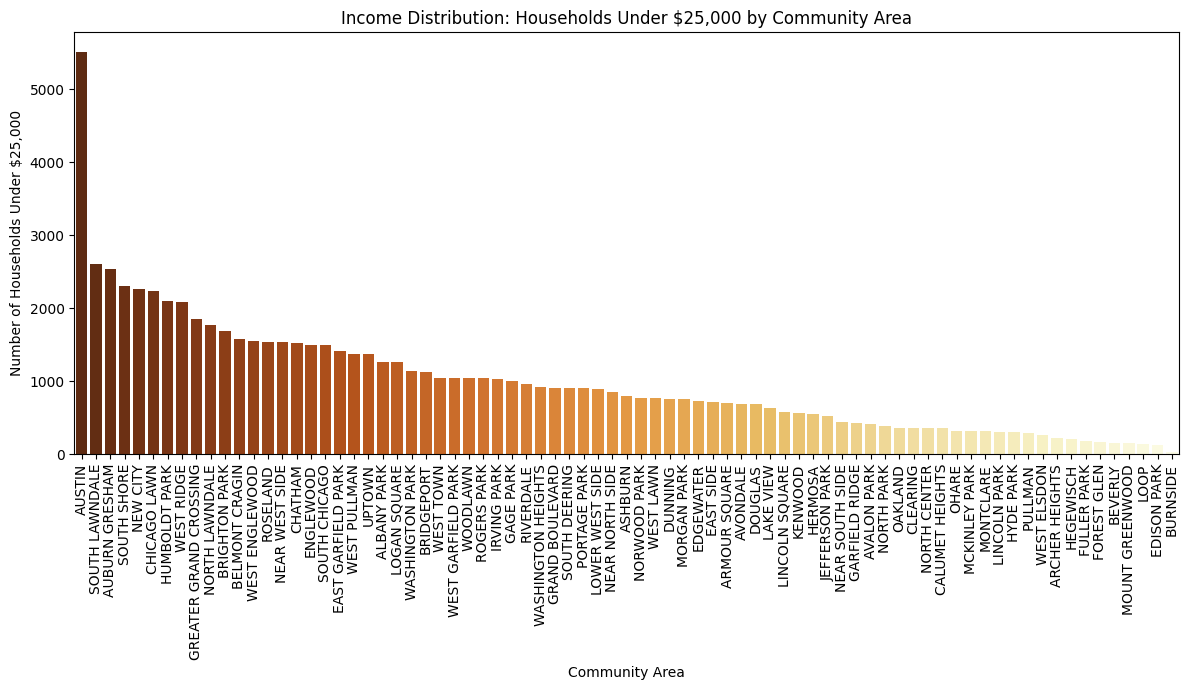

In [12]:
# Assuming your DataFrame is named pop_data
plt.figure(figsize=(12, 7))

sns.barplot(
    data=pop_data.sort_values(by="Under $25,000", ascending=False),
    x="Community Area",
    y="Under $25,000",
    palette="YlOrBr_r",
    hue = "Community Area"
)

plt.xticks(rotation=90)  # rotate labels for readability
plt.title("Income Distribution: Households Under $25,000 by Community Area")
plt.xlabel("Community Area")
plt.ylabel("Number of Households Under $25,000")

plt.tight_layout()
plt.show()

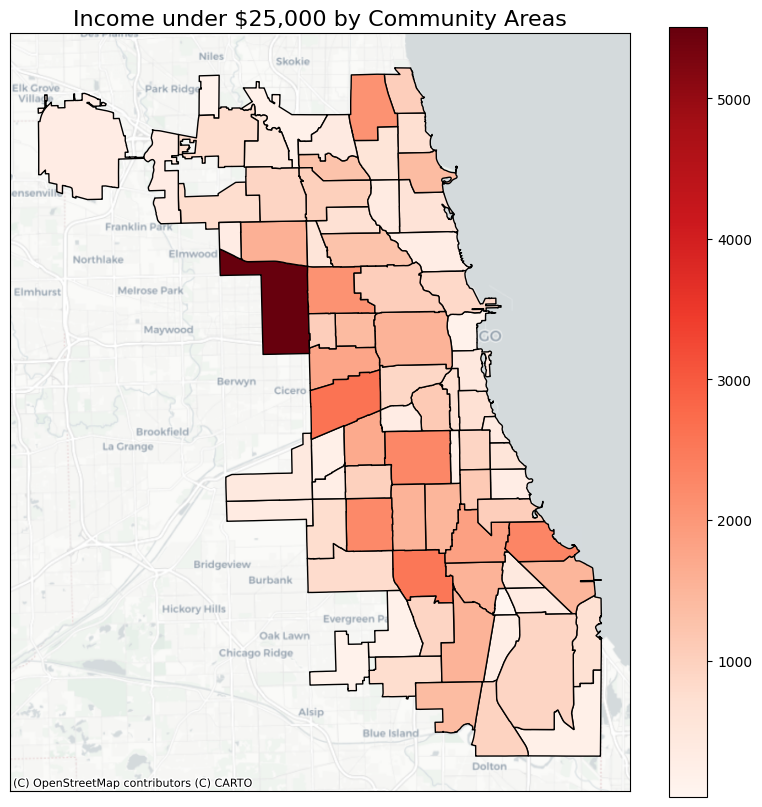

In [13]:
#Make a map of the crimes in Chicago by community areas
ax = merged_df.plot(column='Under $25,000', legend=True, cmap='Reds', alpha=1, edgecolor = 'k', figsize=(10, 10))

plt.xticks([])
plt.yticks([])

ctx.add_basemap(ax, crs=dff.crs.to_string(), source="Cartodb Positron")

plt.title('Income under $25,000 by Community Areas', fontsize=16)

# Save the plot to a png file
plt.savefig('poverty_income_in_chicago.png', format='png')

plt.show()

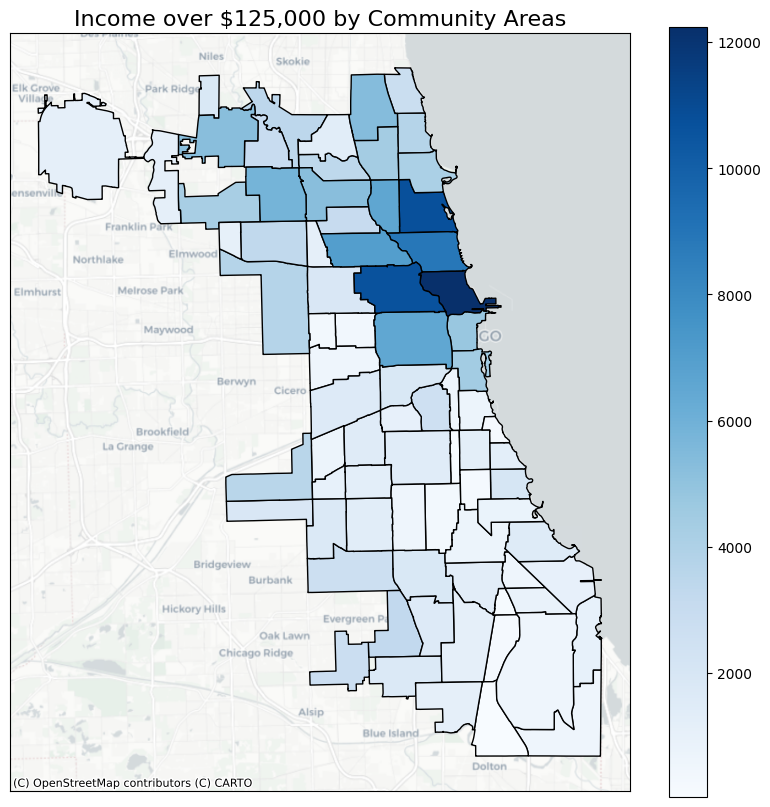

In [14]:
#Make a map of the crimes in Chicago by community areas
ax = merged_df.plot(column='$125,000 +', legend=True, cmap='Blues', alpha=1, edgecolor = 'k', figsize=(10, 10))

plt.xticks([])
plt.yticks([])

ctx.add_basemap(ax, crs=dff.crs.to_string(), source="Cartodb Positron")

plt.title('Income over $125,000 by Community Areas', fontsize=16)

# Save the plot to a png file
plt.savefig('affluence_income_in_chicago.png', format='png')

plt.show()

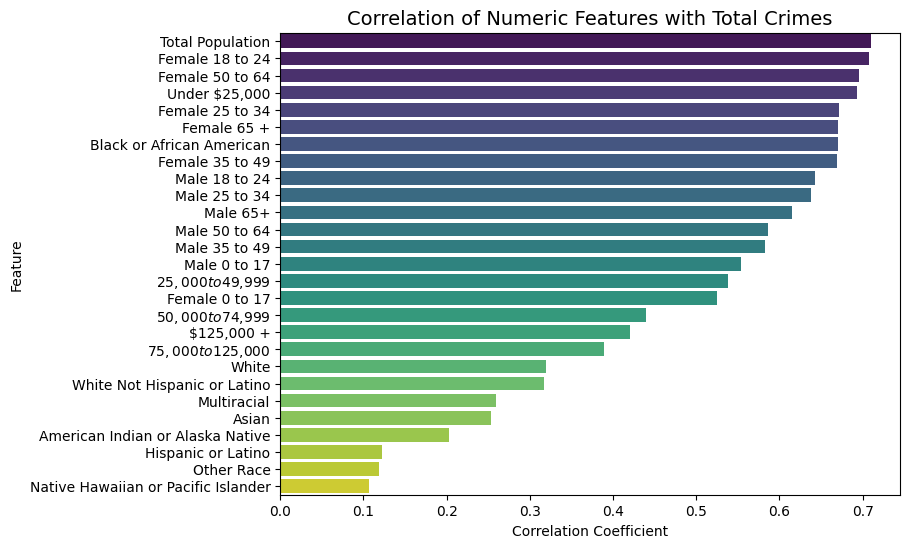

In [15]:
# Select only numeric columns
numeric_df = merged_df.select_dtypes(include=["int64", "float64"])

# Correlation of all numeric columns with Total Crimes, drop itself
crime_corr = numeric_df.corr()["Total Crimes"].drop(["Total Crimes",'ACS Year','Area Number']).sort_values(ascending=False)

# Plot as bar chart
plt.figure(figsize=(8,6))
sns.barplot(x=crime_corr.values, y=crime_corr.index, palette="viridis", hue = crime_corr.index)

plt.title("Correlation of Numeric Features with Total Crimes", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

Pearson correlation: 0.693
P-value: 2.900e-12
R-squared: 0.480


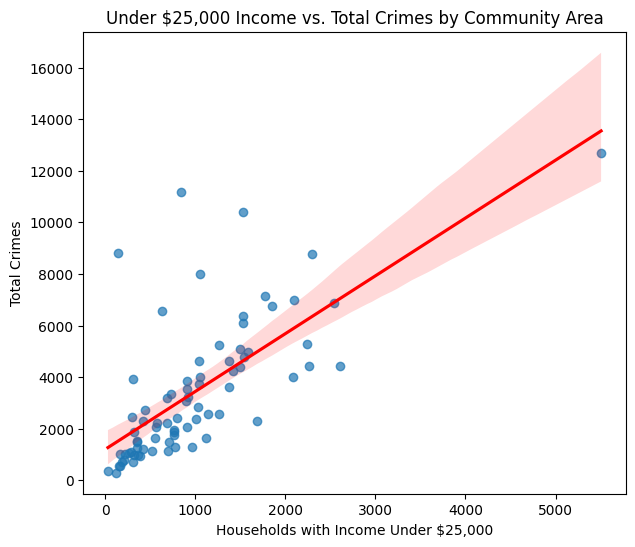

In [16]:
# Calculate Pearson correlation and p-value
corr_val, p_val = pearsonr(merged_df["Under $25,000"], merged_df["Total Crimes"])

print(f"Pearson correlation: {corr_val:.3f}")
print(f"P-value: {p_val:.3e}")

# Optional: R-squared (strength of linear relationship)
r_squared = (corr_val)**2
print(f"R-squared: {r_squared:.3f}")

# Scatter plot with regression line
plt.figure(figsize=(7,6))
sns.regplot(
    data=merged_df,
    x="Under $25,000",
    y="Total Crimes",
    scatter_kws={"alpha":0.7},
    line_kws={"color":"red"}
)

plt.title("Under $25,000 Income vs. Total Crimes by Community Area")
plt.xlabel("Households with Income Under $25,000")
plt.ylabel("Total Crimes")
plt.show()

In [17]:
# --- Prepare GeoDataFrame ---
g = merged_df.copy()

# Make sure geometry column is set
g = g.rename(columns={'the_geom': 'geometry'}).set_geometry('geometry')
g = g.to_crs(epsg=4326)   # folium needs WGS84

# Create a simpler key for matching
g['community_key'] = g['Community Area'].astype(str)

# --- Base map ---
m = folium.Map(location=[41.85, -87.7], tiles="CartoDB positron",
               zoom_start=10, width=600, height=600)

# --- Choropleth ---
folium.Choropleth(
    geo_data=g,
    data=g,
    columns=["community_key", "Total Crimes"],
    key_on="feature.properties.community_key",
    fill_color="OrRd",
    legend_name="Total Number of Crimes",
    fill_opacity=0.8,
    line_opacity=0.3,
    bins=9
).add_to(m)

# --- Tooltip fields (from your column list) ---
tooltip_fields = [
    'Community Area', 'Area Number', 'Total Crimes', 'ACS Year',
    'Under $25,000', '$25,000 to $49,999', '$50,000 to $74,999',
    '$75,000 to $125,000', '$125,000 +',
    'Total Population', 'White', 'Black or African American',
    'Asian', 'Hispanic or Latino'
]

tooltip_aliases = [
    'Community Area: ', 'Area Number: ', 'Total Crimes: ', 'ACS Year: ',
    'Under $25,000: ', '$25,000 to $49,999: ', '$50,000 to $74,999: ',
    '$75,000 to $125,000: ', '$125,000 +: ',
    'Total Population: ', 'White: ', 'Black or African American: ',
    'Asian: ', 'Hispanic or Latino: '
]

folium.GeoJson(
    g[['community_key', 'geometry'] + tooltip_fields],
    style_function=lambda x: {'fillColor': '#ffffff', 'color': '#000000',
                              'fillOpacity': 0.1, 'weight': 0.1},
    highlight_function=lambda x: {'fillColor': '#000000', 'color': '#000000',
                                  'fillOpacity': 0.1, 'weight': 0.1},
    tooltip=folium.GeoJsonTooltip(
        fields=tooltip_fields,
        aliases=tooltip_aliases,
        sticky=True
    )
).add_to(m)

# Save/display
m.save("crime_map.html")
m